## Análisis de Sentimiento (in inglish pitinglish)


#### 1.1 Cargamos librerías

In [49]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud
import json

# visuals
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# spacy & regex
import re
import spacy
from spacy import displacy
from spacy.matcher import PhraseMatcher
from spacy.matcher import Matcher

# warnings
import warnings
warnings.filterwarnings('ignore')

#NLTK
from nltk.stem import *
from nltk.stem.porter import *

stemmer = PorterStemmer()

#### 1.2. Cargamos los datos

In [50]:
df = pd.read_csv("./input/tweets_castellano.txt", sep="::::", names=['review','review_type'] ,encoding="utf-8")
df.shape

(7219, 2)

In [51]:
df.head()

review review_type
0        Salgo de #VeoTV , que día más largoooooo...        None
1  @PauladeLasHeras No te libraras de ayudar me/n...      neutro
2                          @marodriguezb Gracias MAR    positivo
3  Off pensando en el regalito Sinde, la que se v...    negativo
4  Conozco a alguien q es adicto al drama! Ja ja ...    positivo

#### 1.3. Crea una columna que tenga todas las reviews, positivas y negativas. Crea otra que diga si es buena o mala, dependiendo del reviewer_Score


In [52]:
# vemos el nombre de las columnas del dataset
list(df.columns)

['review', 'review_type']

In [53]:
# realizamos rename de las columnas
df["review_type"] =df["review_type"].replace("None", "neutro").replace(":negativo", "negativo").replace(":positivo", "positivo")


In [54]:
# seleccionamos las columnas necesarias
df = df[["review", "review_type"]]
df.review_type.value_counts()

positivo    2884
negativo    2183
neutro      2152
Name: review_type, dtype: int64

In [55]:
# visualizamos las columnas seleccionadas
df

review review_type
0           Salgo de #VeoTV , que día más largoooooo...      neutro
1     @PauladeLasHeras No te libraras de ayudar me/n...      neutro
2                             @marodriguezb Gracias MAR    positivo
3     Off pensando en el regalito Sinde, la que se v...    negativo
4     Conozco a alguien q es adicto al drama! Ja ja ...    positivo
...                                                 ...         ...
7214  Muy indignante si ...nadie repara en ello hoy ...    negativo
7215  Más pobres por discriminar a la mujer http://t...    negativo
7216  Crean un banco de productos para mujeres con c...    positivo
7217  Sobre la sorprendente huída hoy en el Senado d...    negativo
7218  #CorreMarianoCorre está muy bien pero la versi...    positivo

[7219 rows x 2 columns]

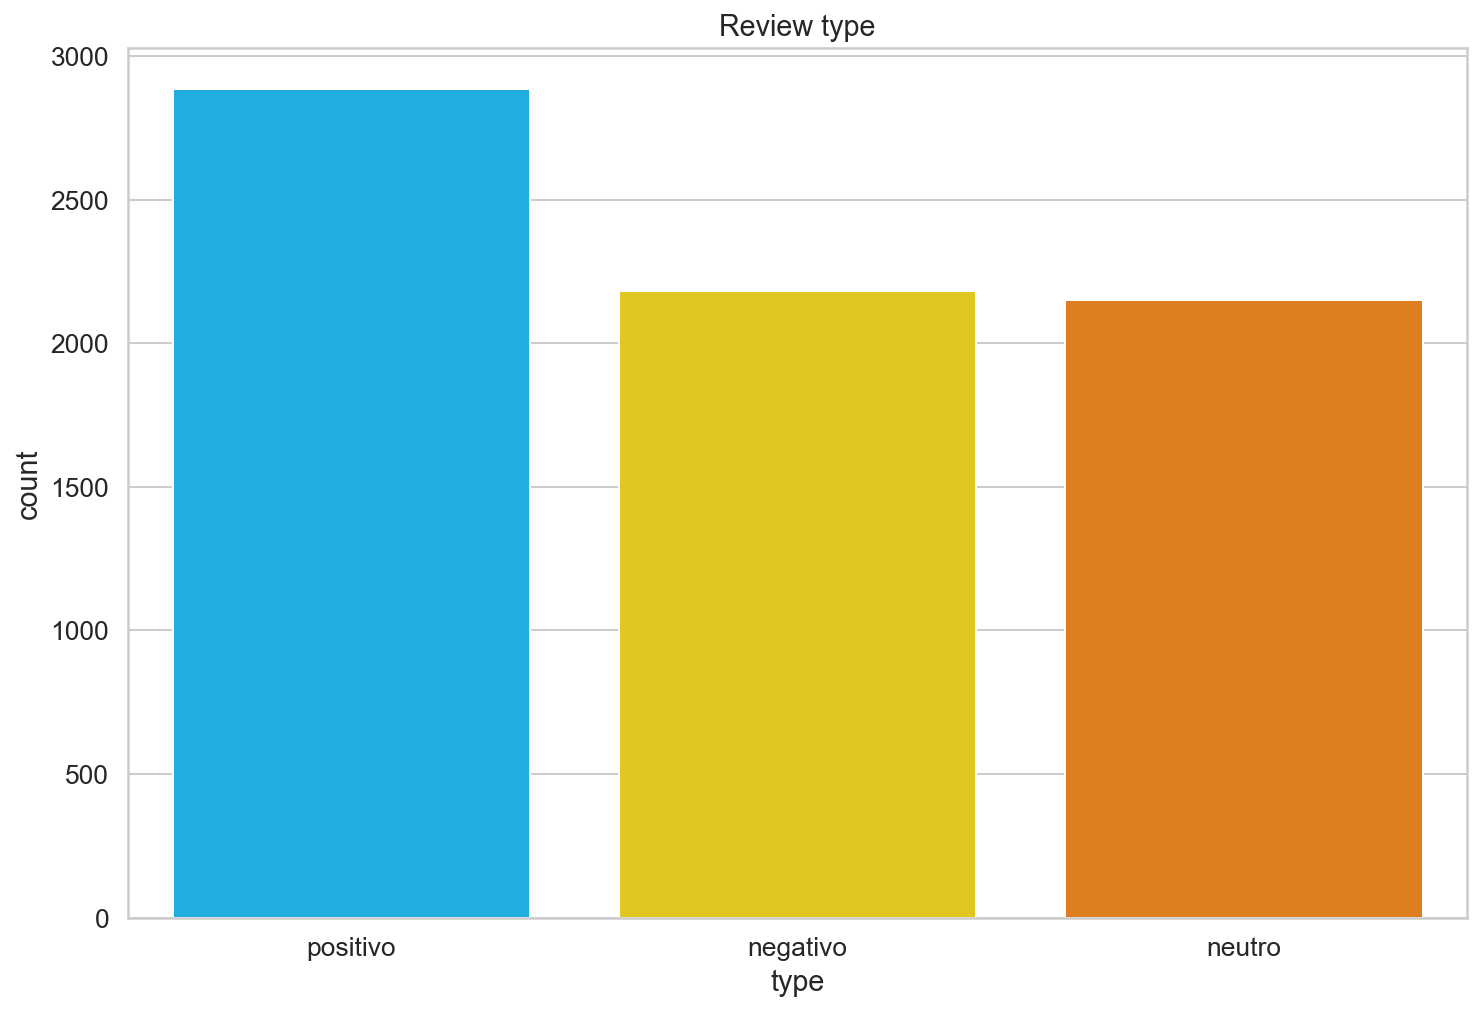

In [56]:
# comprobación
sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

#### 1.4. Crea una WordCloud a partir de estas columnas

In [ ]:
# código para cargar un fichero texto y convertirlo en un conjunto
with open("./input/spanish.txt","r",encoding="utf-8") as fichero:
    stopwordsSP = set([palabra[:-1] for palabra in fichero.readlines()])
    
#stopwordsSP

In [58]:
# limpieza de texto
df["review"] = df["review"].apply(lambda x: re.sub(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+|)", '', x))
df["review"] = df["review"].apply(lambda x: re.sub(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+|)", '', x))
df["review"] = df["review"].apply(lambda x: re.sub(r"http\S+|(:|”|“)", '', x))
df["review"] = df["review"].apply(lambda x: re.sub(r"#", '', x))
df["review"] = df["review"].apply(lambda x: re.sub(r"(|www\.)(\S+\.)(es|com|org)|(:|”|“)", '', x))

In [59]:
# limpieza de texto con REGEX

def clean_tweets_urls(text, stem=False):
  text_cleaning_regex = '(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)(t.co\/\w+)'
  # Text passed to the regex equatio
  text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stopwordsSP:
      if stem:
        # Paased to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        # A
        tokens.append(token)
  return " ".join(tokens)


def clean_tweets_rt(text, stem=False):
  text_cleaning_regex = ' (RT|rt|d|D|q|Q|t|T|x|X) '
  # Text passed to the regex equatio
  text = re.sub(text_cleaning_regex, '', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stopwordsSP:
      if stem:
        # Paased to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        # A
        tokens.append(token)
  return " ".join(tokens)

In [60]:
#df.review = df.review.apply(lambda x: clean_tweets_urls(x))
#df.review = df.review.apply(lambda x: clean_tweets_rt(x))

In [61]:
good_reviews = df[df.review_type == "positivo"]
bad_reviews = df[df.review_type == "negativo"]
neutro_reviews = df[df.review_type == "neutro"]

In [62]:
print(good_reviews.shape, bad_reviews.shape, neutro_reviews.shape)

(2884, 2) (2183, 2) (2152, 2)


In [63]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())
neutro_reviews_text = " ".join(neutro_reviews.review.to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=stopwordsSP, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=stopwordsSP, background_color="white").generate(bad_reviews_text)
neutro_reviews_cloud = WordCloud(stopwords=stopwordsSP, background_color="white").generate(neutro_reviews_text)

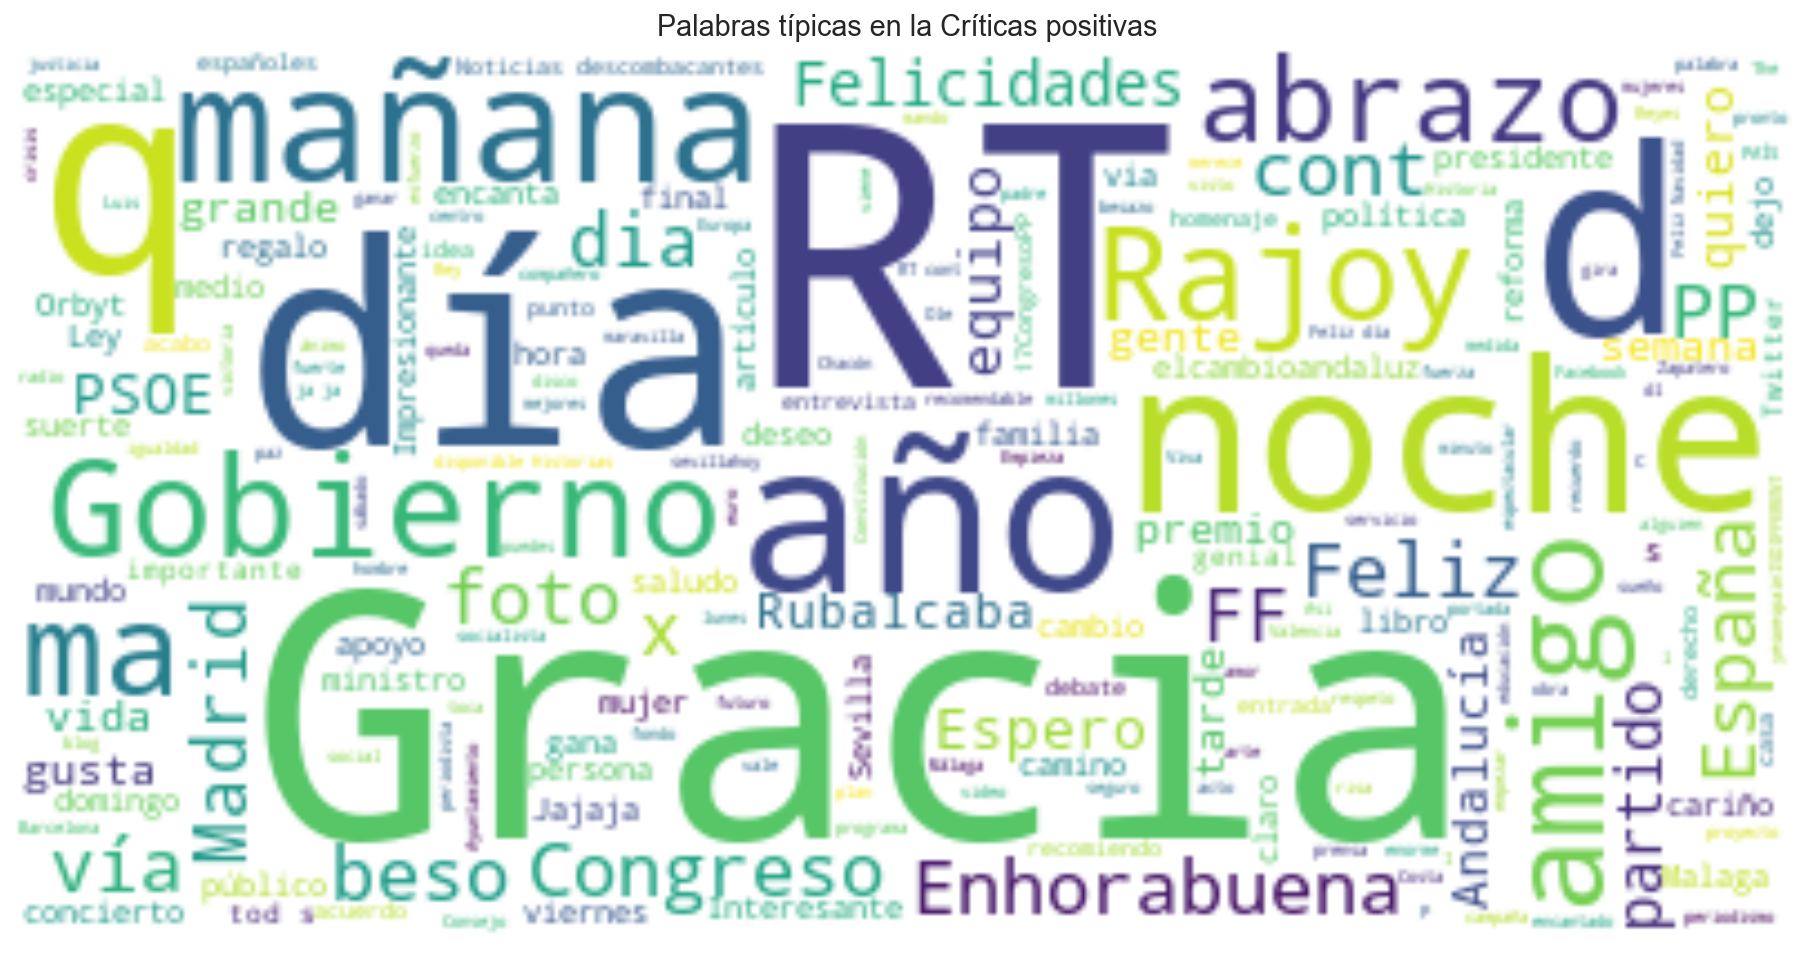

In [64]:
def show_word_cloud(cloud, title):
    plt.figure(figsize = (16, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show();
    
show_word_cloud(good_reviews_cloud, "Palabras típicas en la Críticas positivas")

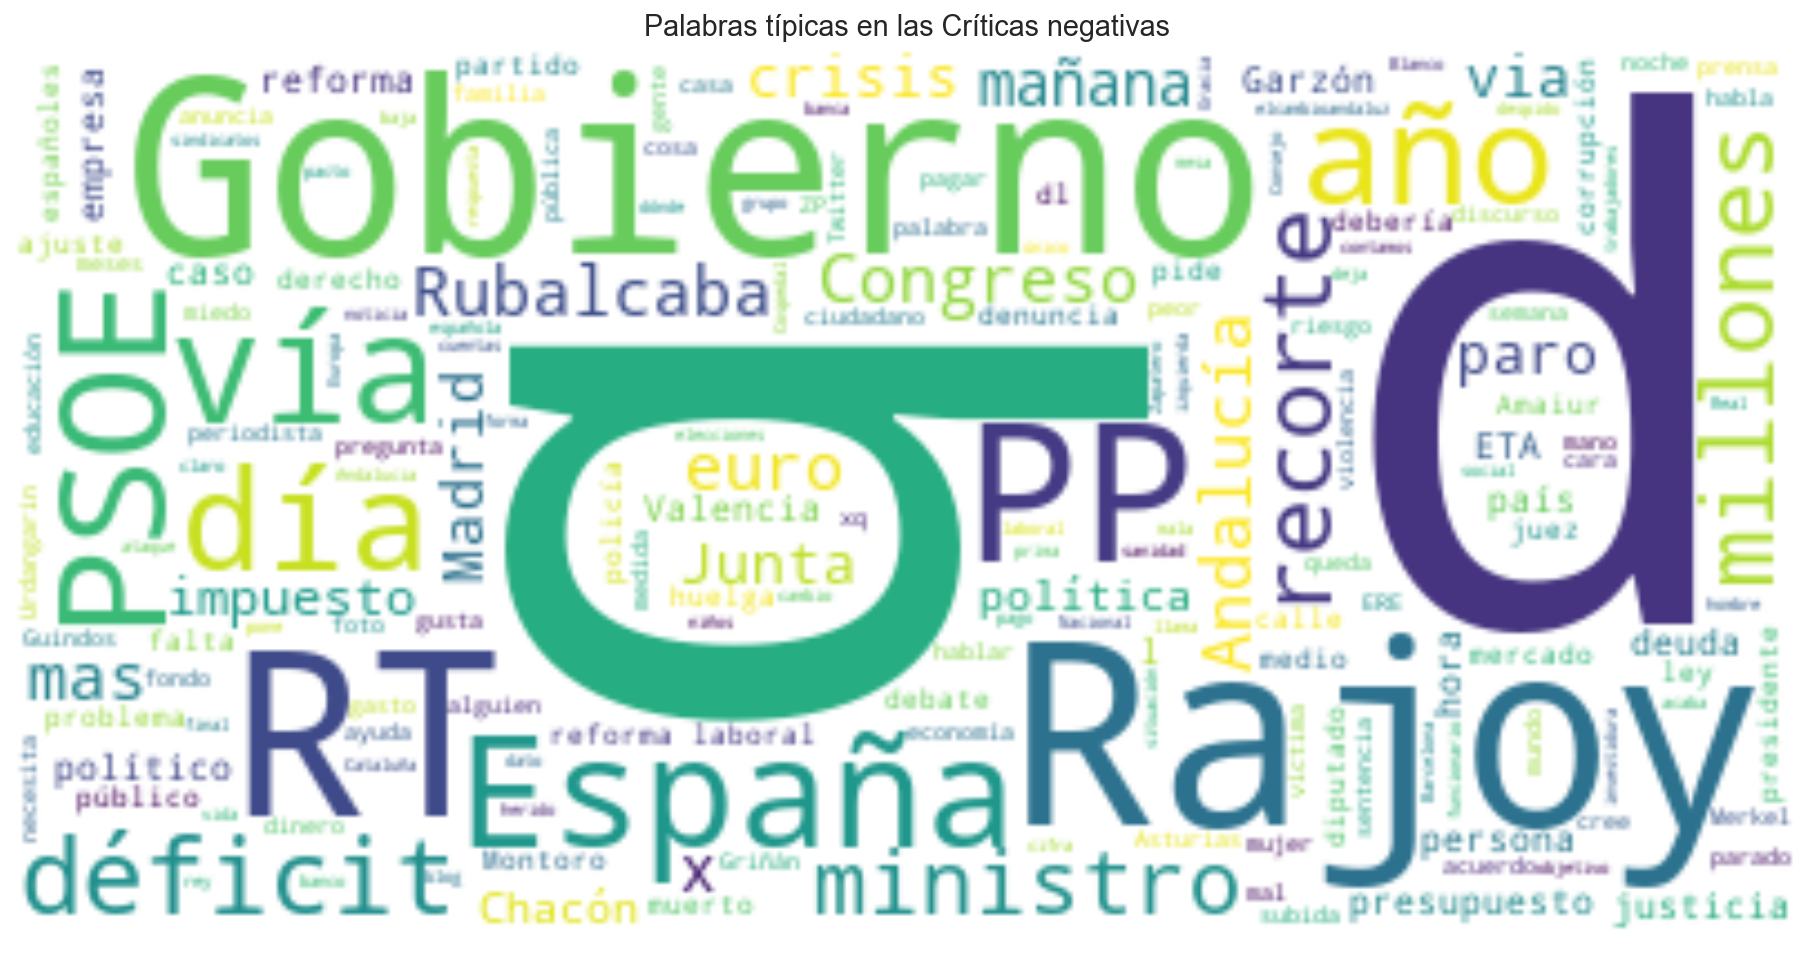

In [65]:
show_word_cloud(bad_reviews_cloud, "Palabras típicas en las Críticas negativas")

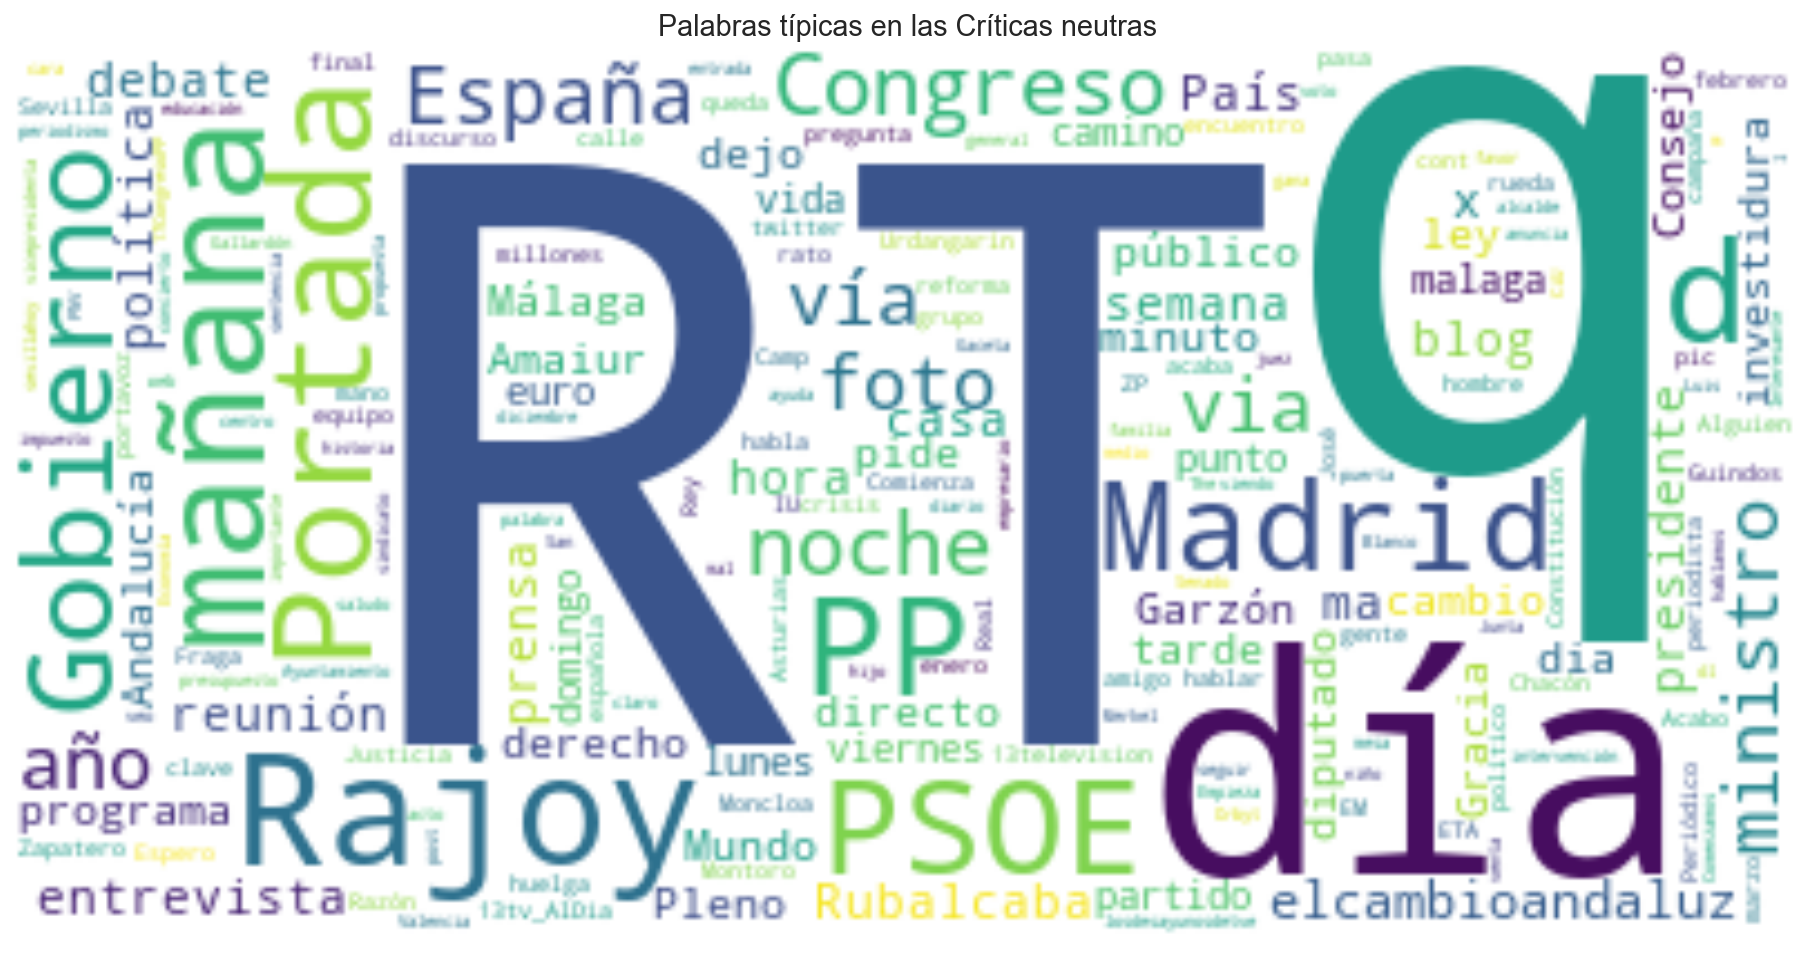

In [66]:
show_word_cloud(neutro_reviews_cloud, "Palabras típicas en las Críticas neutras")

#### 1.5. Unimos los dos, buenas y malas para sacar un review_df total

In [67]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)
bad_df = bad_reviews
neutro_df = neutro_reviews

review_df = good_df.append(bad_df).reset_index(drop=True)
#review_df = good_df.append(neutro_df).reset_index(drop=True)

review_df.shape

(4366, 2)

In [68]:
# comprobacion
review_df.head()

review review_type
0  Margallo recupera la Secretaría de Estado para...    positivo
1  RT  Dicen que gana Rubalcaba. Falta la confirm...    positivo
2  Preparo artículo sobre futuro de la lengua. Sa...    positivo
3  (2) La reforma laboral tiene aspectos interesa...    positivo
4  Muchas gracias Ana. Un aBrazo RT   buenísimo, ...    positivo

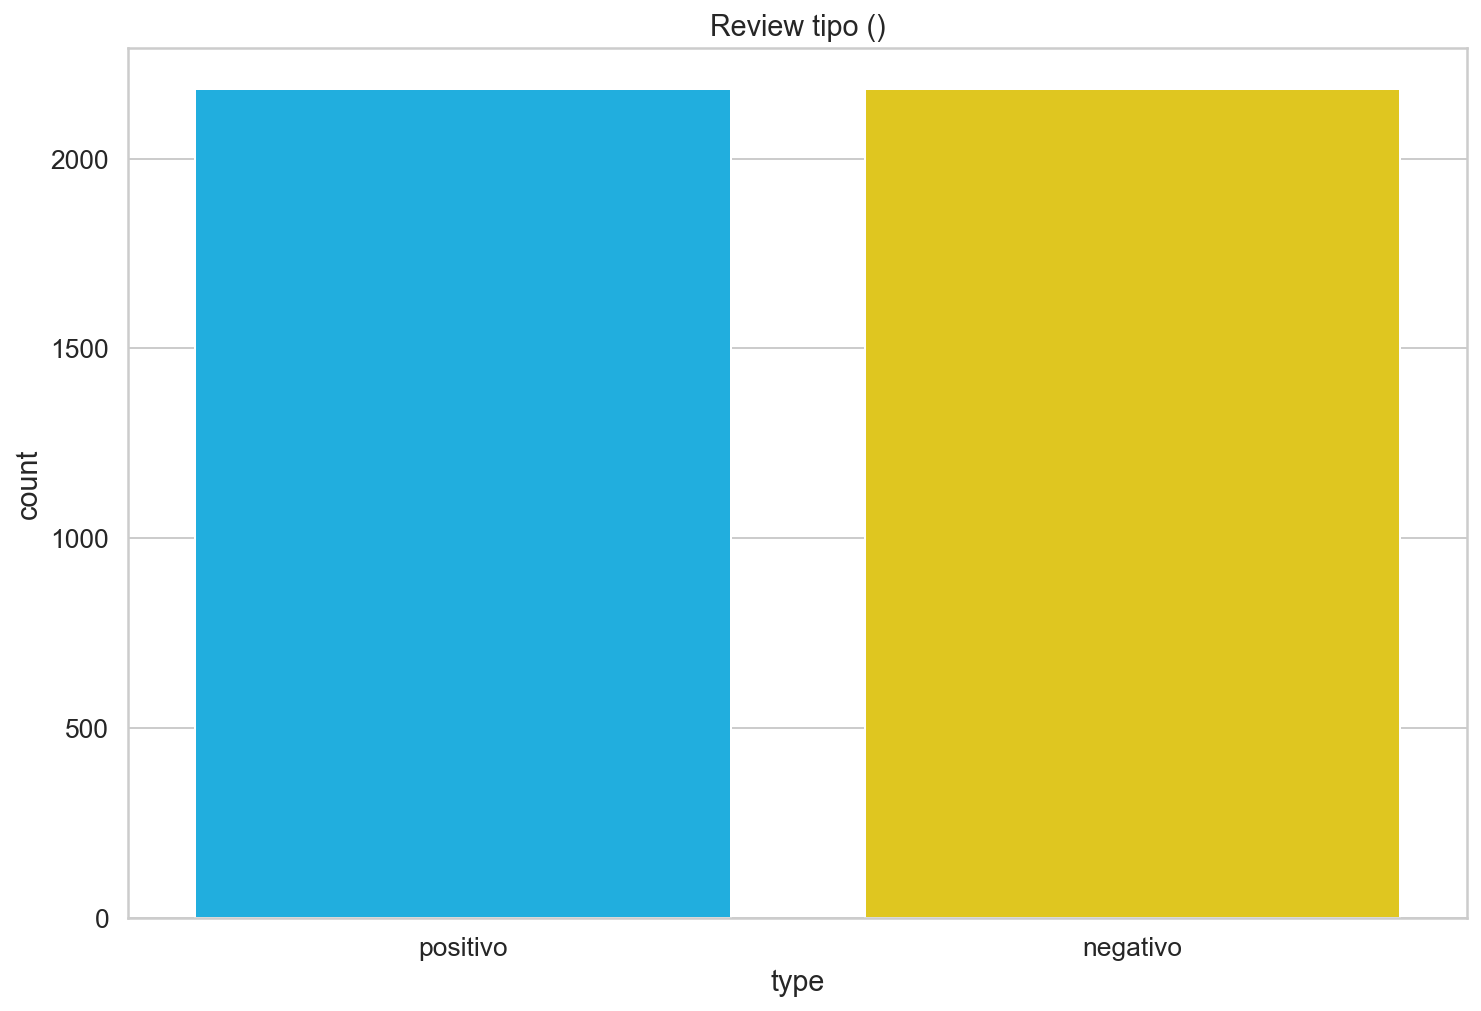

In [69]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review tipo ()");

## 2. Preprocesado

#### 2.1 Convierte la columna review_type en one hot 

In [70]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

#### 2.2 Divide en train_reviews e y_train y test_reviews e y_test

In [71]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.2, 
    random_state=RANDOM_SEED
  )

In [72]:
# cargamos el universal sentence encoder
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [25]:
# procesamos el train
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 3492/3492 [02:26<00:00, 23.85it/s]


In [26]:
X_train

array([[-0.03583278,  0.00328916,  0.00392127, ..., -0.09914102,
        -0.02956253, -0.00954142],
       [-0.00267765,  0.03971003, -0.04531154, ..., -0.12707897,
         0.02617391, -0.03551852],
       [ 0.02826573,  0.0560347 ,  0.01948786, ...,  0.00405756,
         0.01783251,  0.03886177],
       ...,
       [ 0.03697858,  0.09434138,  0.04087063, ...,  0.06151699,
         0.01345199, -0.03332451],
       [ 0.01875407, -0.02053458, -0.00190016, ..., -0.04138729,
        -0.04776346, -0.105014  ],
       [ 0.00021765, -0.04419821,  0.06105333, ...,  0.04985294,
         0.0153308 ,  0.00319648]], dtype=float32)

In [27]:
X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 874/874 [00:37<00:00, 23.41it/s]


In [28]:
X_test

array([[ 0.00373967, -0.0383916 , -0.03116526, ...,  0.0004257 ,
        -0.00409236, -0.0357571 ],
       [-0.09454449, -0.07868036,  0.00016517, ..., -0.01744654,
         0.01853141, -0.03005794],
       [-0.07322834, -0.0583455 , -0.00308562, ..., -0.02400602,
        -0.01160461, -0.01149068],
       ...,
       [-0.03492811,  0.07361931,  0.00380244, ...,  0.04236001,
         0.08327736, -0.05222198],
       [ 0.06946699, -0.01418474,  0.04134221, ...,  0.00545431,
         0.03475112,  0.00261986],
       [ 0.01242077, -0.06599478, -0.0221638 , ..., -0.00211412,
         0.04178473,  0.02822172]], dtype=float32)

In [29]:
print(X_train.shape, X_test.shape)

(3492, 512) (874, 512)


In [30]:
print(X_train.shape, y_train.shape)

(3492, 512) (3492, 2)


## 3 Modelo de Análisis de sentimiento

Queremos una secuencia 
- Capa densa de 256, que le entra la X_train y activacion relu
- Dropout de .5
- Otra densa de 128 activacion relu
- Otra Dropout de .5
- y la salida densa de 2 softmax


In [31]:
# model
model = keras.Sequential()

model.add(keras.layers.Dense(units=256,input_shape=(X_train.shape[1], ), activation='sigmoid'))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(units=128, activation='sigmoid'))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


In [32]:
# va a monitorizar varias métricas, la precisión de validación, la pérdida, etc. y cuando vaya a peor para el proceso
early_stopping = EarlyStopping(monitor='loss',patience=5)

# guardado de modelo
modelo_guardar = ModelCheckpoint('model_sentiment_analysis_regex.hdf5', save_best_only=True) # con save_best_only = Nos guardaria el mejor

In [33]:
# compilación de modelo
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [34]:
# training
history = model.fit(X_train, y_train, epochs=40, batch_size=16, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping, modelo_guardar]) 

Epoch 1/40
219/219 [==============================] - 1s 3ms/step - loss: 0.7403 - accuracy: 0.5410 - val_loss: 0.6187 - val_accuracy: 0.7586
Epoch 2/40
219/219 [==============================] - 1s 2ms/step - loss: 0.5957 - accuracy: 0.6816 - val_loss: 0.4963 - val_accuracy: 0.7677
Epoch 3/40
219/219 [==============================] - 1s 2ms/step - loss: 0.4844 - accuracy: 0.7592 - val_loss: 0.4038 - val_accuracy: 0.8238
Epoch 4/40
219/219 [==============================] - 1s 2ms/step - loss: 0.4399 - accuracy: 0.7998 - val_loss: 0.3849 - val_accuracy: 0.8318
Epoch 5/40
219/219 [==============================] - 1s 2ms/step - loss: 0.4220 - accuracy: 0.8150 - val_loss: 0.3701 - val_accuracy: 0.8387
Epoch 6/40
219/219 [==============================] - 0s 2ms/step - loss: 0.3987 - accuracy: 0.8270 - val_loss: 0.3778 - val_accuracy: 0.8387
Epoch 7/40
219/219 [==============================] - 0s 2ms/step - loss: 0.3872 - accuracy: 0.8302 - val_loss: 0.3646 - val_accuracy: 0.8467
Epoch 

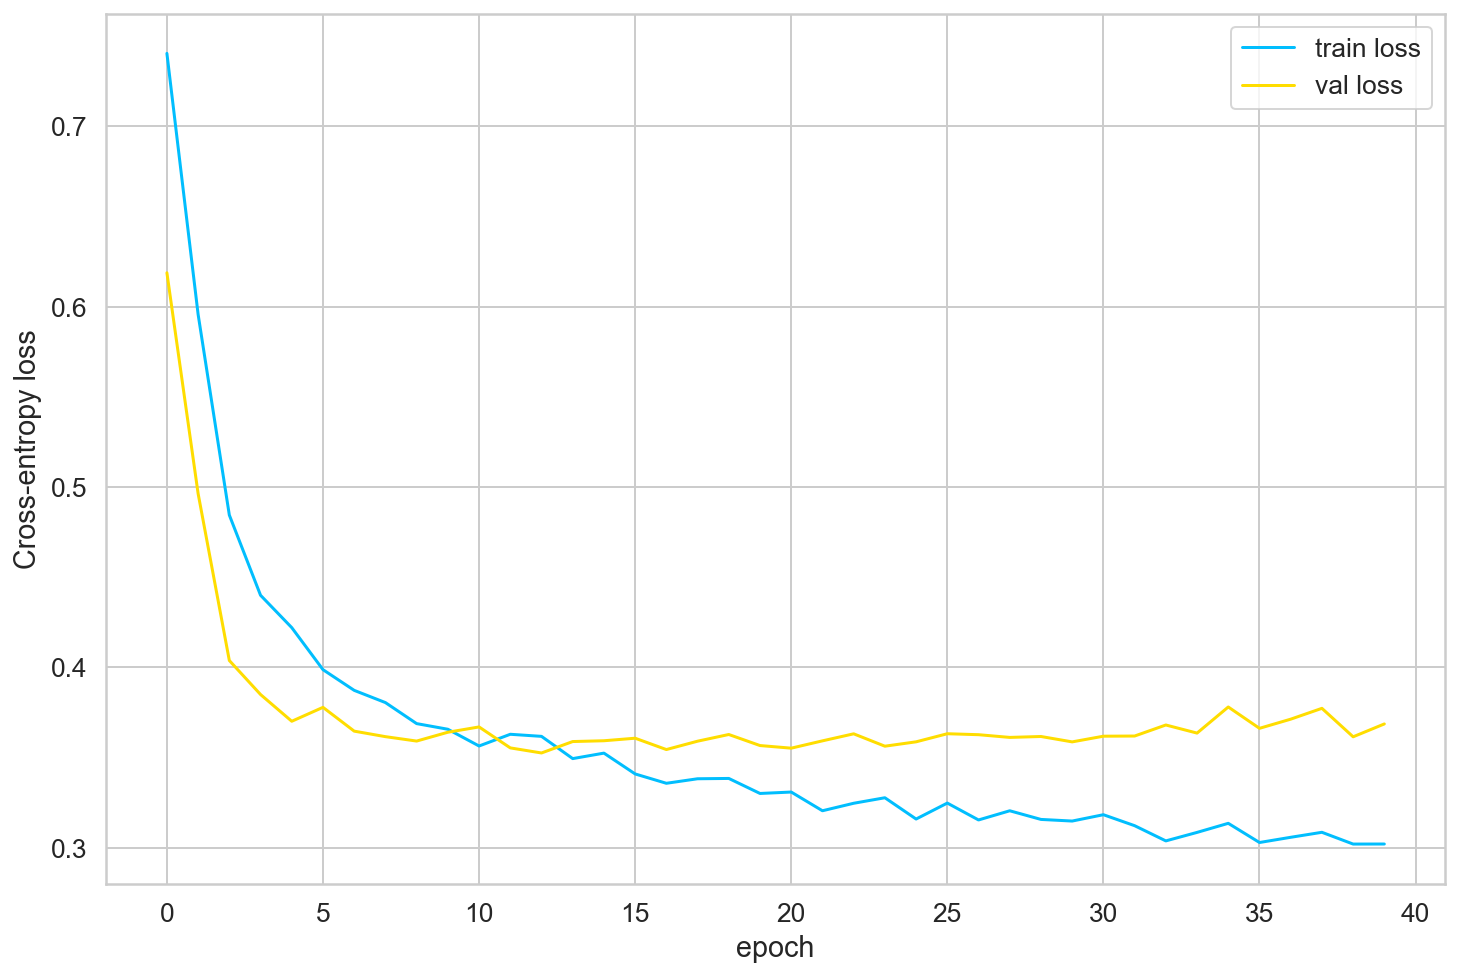

In [35]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

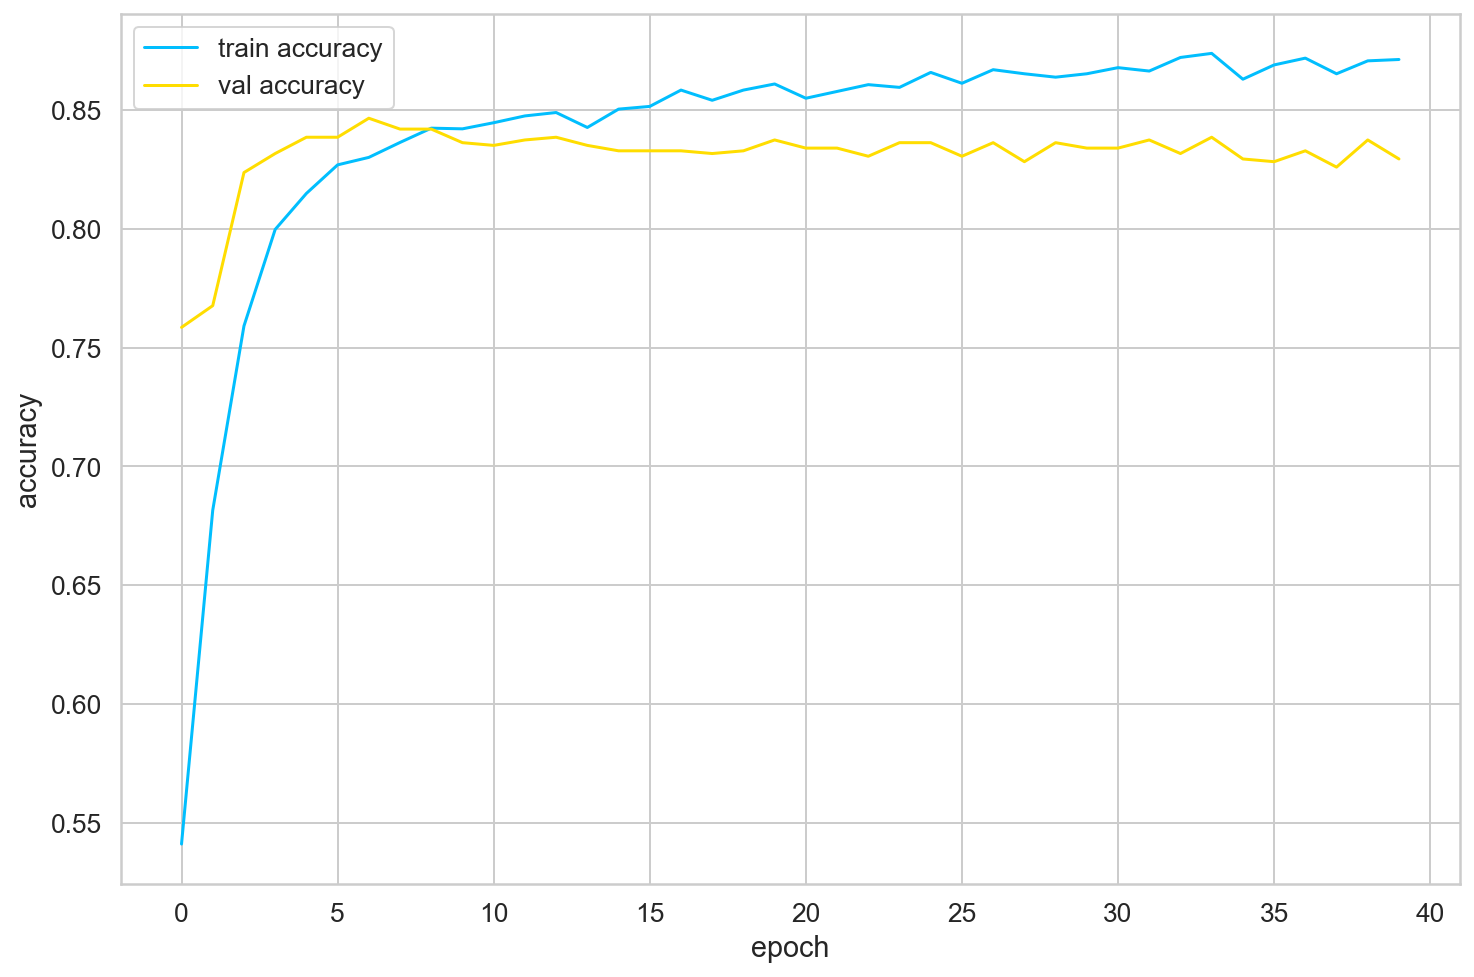

In [36]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

### 4.1. Como evaluariamos el test

In [37]:
# modelo de evaluación
model.evaluate(X_test, y_test)

28/28 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8295


[0.36862611770629883, 0.8295194506645203]

In [38]:
from sklearn.metrics import classification_report, accuracy_score
predictions = model.predict(X_test)
predictions = np.around(predictions)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

28/28 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       404
           1       0.90      0.77      0.83       470

   micro avg       0.83      0.83      0.83       874
   macro avg       0.83      0.83      0.83       874
weighted avg       0.84      0.83      0.83       874
 samples avg       0.83      0.83      0.83       874

0.8295194508009154


## 5. Predicciones

#### 5.1. Saca la predicción de una review

In [39]:
print(test_reviews.iloc[0])
print("Mala" if y_test[0][0] == 1 else "Buena")

Pero muy buenas! 
Buena


In [40]:
# predicción 1
y_pred = model.predict(X_test[:1])
print(y_pred)
"Mala" if np.argmax(y_pred) == 0 else "Buena"

1/1 [==============================] - 0s 17ms/step
[[0.00146874 0.9985312 ]]


'Buena'

In [41]:
# predicción 2
print(test_reviews.iloc[2])
print("Mala" if y_test[1][0] == 1 else "Buena")

ff para   dos grandes periodistas que respeto, reconozco y animo. Con un fuerte abrazo.
Buena


In [42]:
# predicción 3
y_pred = model.predict(X_test[1:2])
print(y_pred)
"Mala" if np.argmax(y_pred) == 0 else "Buena"

1/1 [==============================] - 0s 15ms/step
[[0.6591951  0.34080487]]


'Mala'